In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df_train = pd.read_csv('train.csv')
df_features = pd.read_csv('features.csv')
df_stores = pd.read_csv('stores.csv')

In [3]:
# merge Datasets
df = df_train.merge(df_features, on=['Store', 'Date'], how='left')
df = df.merge(df_stores, on='Store', how='left')

In [4]:
# 4.basic Info
print("Dataset Shape:", df.shape)
print("\nColumn Names:")
print(df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nFirst Few Rows:")
print(df.head())

Dataset Shape: (421570, 17)

Column Names:
['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday_x', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday_y', 'Type', 'Size']

Data Types:
Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday_x        bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday_y        bool
Type             object
Size              int64
dtype: object

First Few Rows:
   Store  Dept        Date  Weekly_Sales  IsHoliday_x  Temperature  \
0      1     1  2010-02-05      24924.50        False        42.31   
1      1     1  2010-02-12      46039.49         True        38.51   
2      1     1  2010-02-19      41595.55        False        39.93   
3      1     1  2010

In [5]:
#5c.heck Missing Values
print("Missing Values:")
print(df.isnull().sum())
print("\nMissing Values Percentage:")
print((df.isnull().sum() / len(df)) * 100)

Missing Values:
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday_x          0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday_y          0
Type                 0
Size                 0
dtype: int64

Missing Values Percentage:
Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday_x      0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
IsHoliday_y      0.000000
Type             0.000000
Size             0.000000
dtype: float64


In [6]:
#check Duplicates
duplicates = df.duplicated().sum()
print(f"Number of Duplicate Rows: {duplicates}")

Number of Duplicate Rows: 0


In [7]:
# remove Duplicates
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

Shape after removing duplicates: (421570, 17)


In [8]:
#convert Date Column
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
#fill Missing Values
for col in df.columns:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

print("Missing values after filling:")
print(df.isnull().sum())

Missing values after filling:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday_x     0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
IsHoliday_y     0
Type            0
Size            0
dtype: int64


In [10]:
#create Time-Based Features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

In [11]:
#create Lag Features
df = df.sort_values(['Store', 'Dept', 'Date'])
df['Sales_Lag_1'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df['Sales_Lag_2'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
df['Sales_Lag_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)

In [12]:
#12.create Rolling Averages
df['Sales_Rolling_Mean_4'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)
df['Sales_Rolling_Mean_8'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
    lambda x: x.rolling(window=8, min_periods=1).mean()
)

In [13]:
#13 remove Rows with NaN from Lag Features
df = df.dropna()
print(f"Shape after creating features and removing NaN: {df.shape}")

Shape after creating features and removing NaN: (408436, 28)


In [14]:
#14.statistical Summary
print("Statistical Summary:")
print(df.describe())

Statistical Summary:
               Store           Dept                           Date  \
count  408436.000000  408436.000000                         408436   
mean       22.191548      44.223861  2011-07-03 00:44:53.521628672   
min         1.000000       1.000000            2010-03-05 00:00:00   
25%        11.000000      18.000000            2010-11-05 00:00:00   
50%        22.000000      37.000000            2011-07-01 00:00:00   
75%        33.000000      74.000000            2012-03-02 00:00:00   
max        45.000000      99.000000            2012-10-26 00:00:00   
std        12.783730      30.504301                            NaN   

        Weekly_Sales    Temperature     Fuel_Price      MarkDown1  \
count  408436.000000  408436.000000  408436.000000  408436.000000   
mean    16028.603006      60.803729       3.381032    6048.606356   
min     -4988.940000      -2.060000       2.513000       0.270000   
25%      2119.135000      47.920000       2.961000    5347.450000   
50%

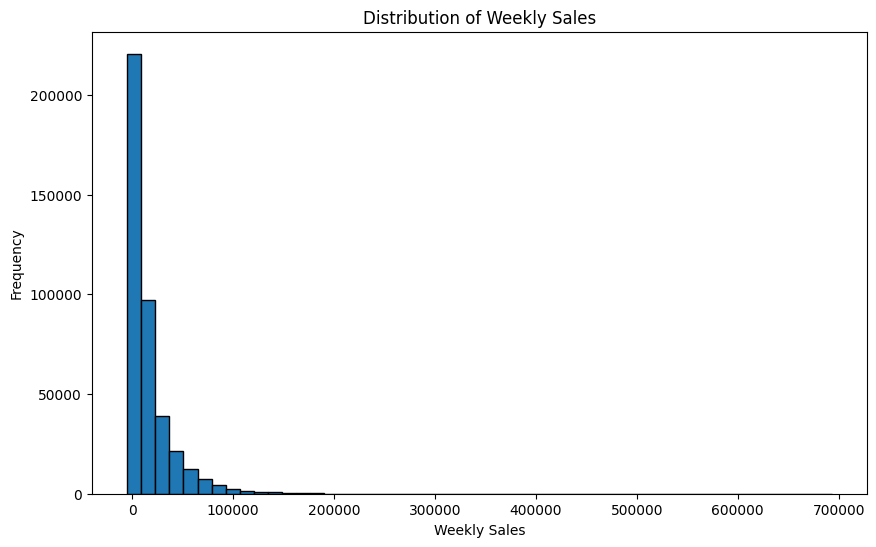

In [15]:
# 15. visualize Sales Distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Weekly_Sales'], bins=50, edgecolor='black')
plt.xlabel('Weekly Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Weekly Sales')
plt.show()

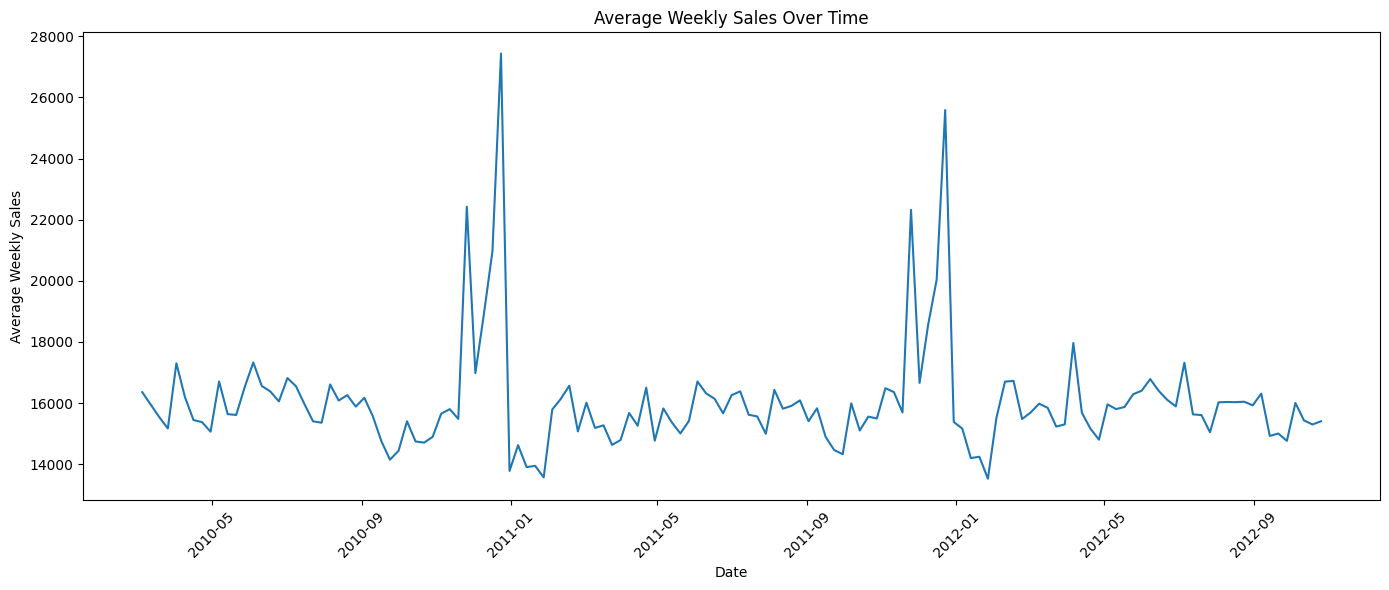

In [16]:
#16 sales Over Time
plt.figure(figsize=(14, 6))
df_time = df.groupby('Date')['Weekly_Sales'].mean().reset_index()
plt.plot(df_time['Date'], df_time['Weekly_Sales'])
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales')
plt.title('Average Weekly Sales Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

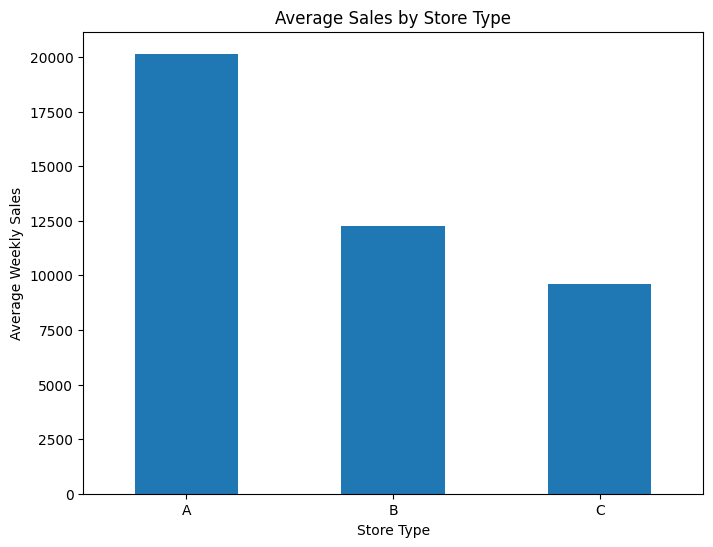

In [17]:
#17sales by Store Type
plt.figure(figsize=(8, 6))
df.groupby('Type')['Weekly_Sales'].mean().plot(kind='bar')
plt.xlabel('Store Type')
plt.ylabel('Average Weekly Sales')
plt.title('Average Sales by Store Type')
plt.xticks(rotation=0)
plt.show()

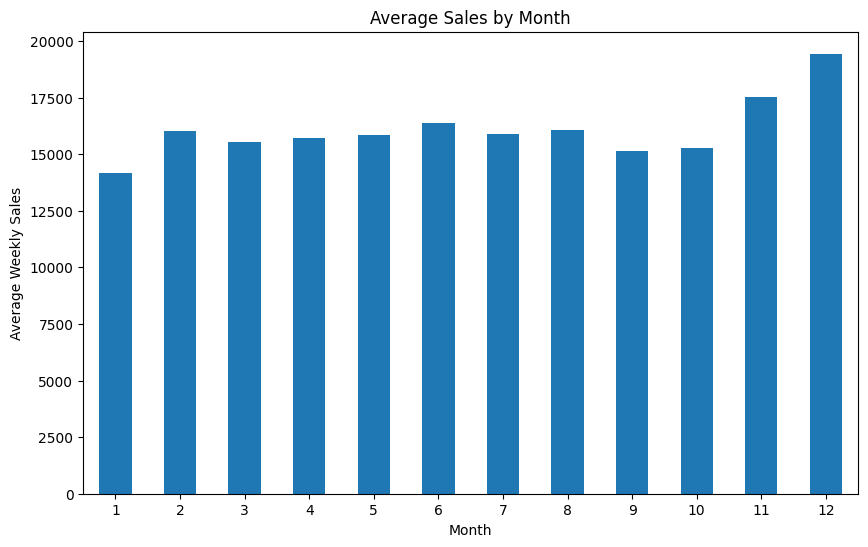

In [18]:
#18 monthly Sales Pattern
plt.figure(figsize=(10, 6))
df.groupby('Month')['Weekly_Sales'].mean().plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Average Weekly Sales')
plt.title('Average Sales by Month')
plt.xticks(rotation=0)
plt.show()

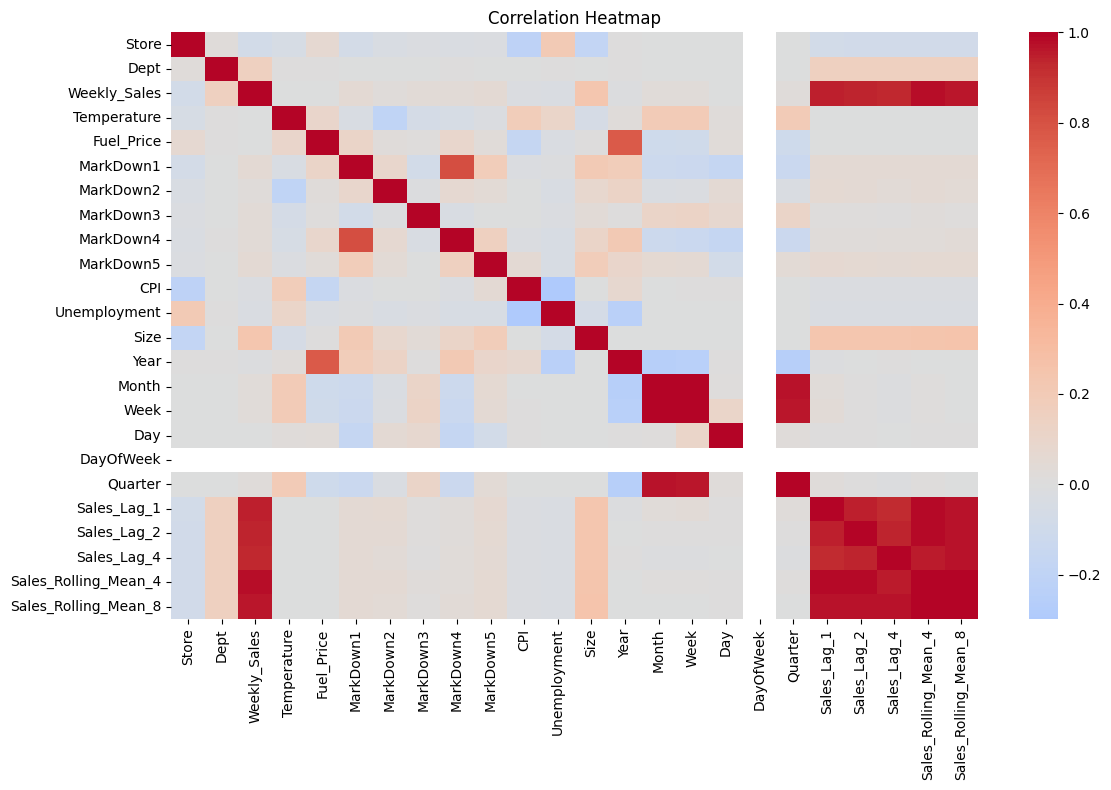

In [19]:
#19: correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [20]:
# 20 prepare Features for Modeling
feature_cols = ['Store', 'Dept', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 
                'Quarter', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_4', 
                'Sales_Rolling_Mean_4', 'Sales_Rolling_Mean_8']

feature_cols = [col for col in feature_cols if col in df.columns]
X = df[feature_cols]
y = df['Weekly_Sales']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

Features shape: (408436, 17)
Target shape: (408436,)


In [21]:
# 21split Data (Time-Series Split)
split_date = df['Date'].quantile(0.8)
train_mask = df['Date'] < split_date
test_mask = df['Date'] >= split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 325663
Test set size: 82773


In [22]:
#22 scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# 23:train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
print("Linear Regression model trained")

Linear Regression model trained


In [24]:
#24: Linear Regression Predictions
y_pred_lr = lr_model.predict(X_test_scaled)

In [25]:
#25:linear Regression Accuracy
lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {lr_rmse:.2f}")
print(f"MAE: {lr_mae:.2f}")
print(f"R2 Score: {lr_r2:.4f}")

Linear Regression Performance:
RMSE: 2207.72
MAE: 1044.59
R2 Score: 0.9899


In [27]:
# 26: Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
print("Random Forest model trained")

Random Forest model trained


In [28]:
#27: Random Forest Predictions
y_pred_rf = rf_model.predict(X_test)

In [29]:
#28: Random Forest Accuracy
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"RMSE: {rf_rmse:.2f}")
print(f"MAE: {rf_mae:.2f}")
print(f"R2 Score: {rf_r2:.4f}")

Random Forest Performance:
RMSE: 1856.31
MAE: 875.62
R2 Score: 0.9929


In [30]:
#29: Compare Models
comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [lr_rmse, rf_rmse],
    'MAE': [lr_mae, rf_mae],
    'R2 Score': [lr_r2, rf_r2]
})
print("\nModel Comparison:")
print(comparison)


Model Comparison:
               Model         RMSE          MAE  R2 Score
0  Linear Regression  2207.717379  1044.585413  0.989903
1      Random Forest  1856.311165   875.615294  0.992862


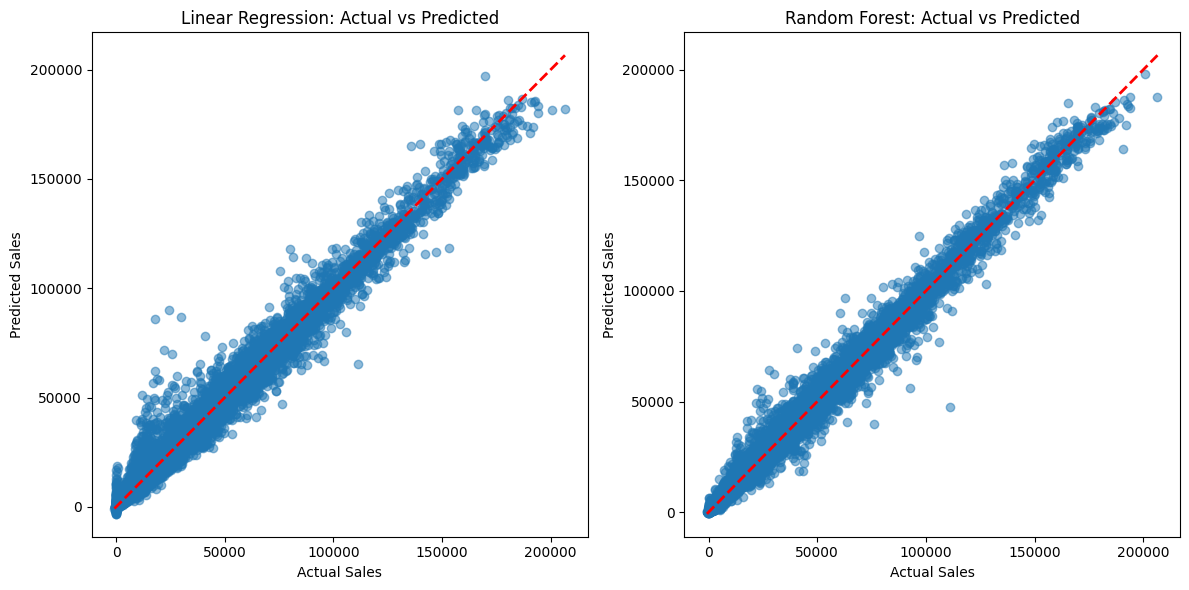

In [31]:
# 30: Plot Actual vs Predicted (Linear Regression)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Linear Regression: Actual vs Predicted')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Random Forest: Actual vs Predicted')
plt.tight_layout()
plt.show()

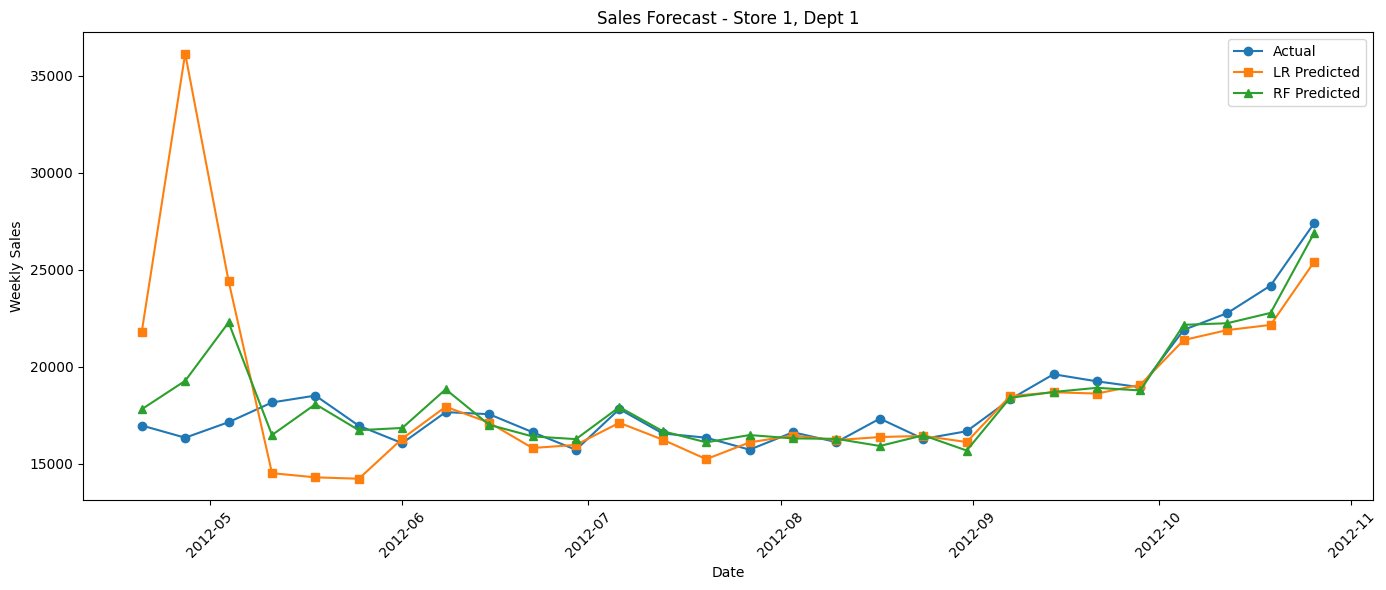

In [32]:
# 31: Plot Time Series Predictions
test_df = df[test_mask].copy()
test_df['Predicted_LR'] = y_pred_lr
test_df['Predicted_RF'] = y_pred_rf

sample_store_dept = test_df.groupby(['Store', 'Dept']).size().idxmax()
sample_data = test_df[(test_df['Store'] == sample_store_dept[0]) & 
                      (test_df['Dept'] == sample_store_dept[1])].sort_values('Date')

plt.figure(figsize=(14, 6))
plt.plot(sample_data['Date'], sample_data['Weekly_Sales'], label='Actual', marker='o')
plt.plot(sample_data['Date'], sample_data['Predicted_LR'], label='LR Predicted', marker='s')
plt.plot(sample_data['Date'], sample_data['Predicted_RF'], label='RF Predicted', marker='^')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title(f'Sales Forecast - Store {sample_store_dept[0]}, Dept {sample_store_dept[1]}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

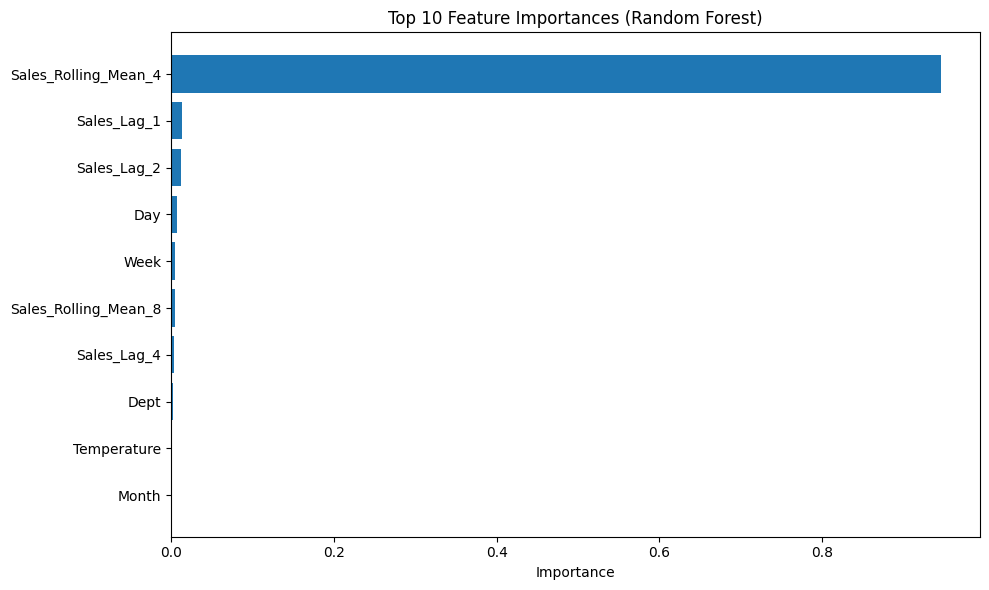

In [33]:
#32: Feature Importance (Random Forest)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [34]:
#33: Save Models
import joblib
joblib.dump(lr_model, 'linear_regression_model.pkl')
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Models saved successfully")

Models saved successfully


In [35]:
#34: Save Predictions
results = pd.DataFrame({
    'Actual_Sales': y_test.values,
    'LR_Predicted': y_pred_lr,
    'RF_Predicted': y_pred_rf
})
results.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv
